In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Convolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input,Reshape

IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
! unzip /content/drive/MyDrive/keyimages

In [ ]:
import numpy as np

Original=os.listdir('/content/keys/images')
Masks=os.listdir('/content/keys/masks')
print(len(Original))
print(len(Masks))

X=np.zeros((len(Original),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.float32)
y=np.zeros((len(Masks),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.float32)

125
125


In [ ]:
print(X.shape)
print(y.shape)

(125, 256, 256, 3)
(125, 256, 256, 3)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
for file in Original:
    n=Original.index(file)
    path1=os.path.join('keys/images',file)
    print(path1)
    img=cv2.imread(path1,1)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    try:
        X[n]=img/255
        file2=Masks[n]
        path2=os.path.join('keys/masks',file2)
        mask=cv2.imread(path2,1)
        mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        mask=cv2.resize(mask,(256,256))
        y[n]=mask/255
    except Exception as e:
        print(e)
        print(path1)

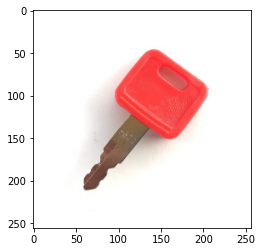

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[1])

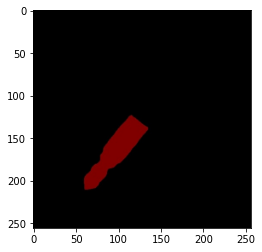

In [ ]:
plt.imshow(y[1])

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [ ]:
masks=y

In [ ]:
masks.shape

(125, 256, 256, 3)

In [ ]:
images=X

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(images,masks,test_size=0.23,random_state=42)

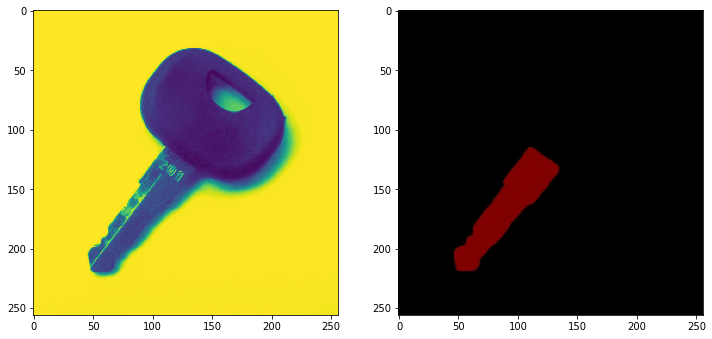

In [ ]:
import random
import numpy as np
img_no=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[img_no,:,:,0])
plt.subplot(122)
plt.imshow(y_train[img_no])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
seed=24
img_data_gen_args=dict(rotation_range=90,
                       shear_range=0.3,
                       zoom_range=0.2,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='reflect')

mask_data_gen_args=dict(rotation_range=90,
                       shear_range=0.3,
                       zoom_range=0.2,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='reflect',
                       preprocessing_function=lambda x: np.where(x>0,255,0).astype(x.dtype))

In [ ]:
batch_size=4

In [ ]:
image_data_generator=ImageDataGenerator(**img_data_gen_args)
image_generator=image_data_generator.flow(X_train,
                                          batch_size=batch_size,
                                          seed=seed)
valid_img_genrator=image_data_generator.flow(X_test,
                                             batch_size=batch_size,
                                             seed=seed)
mask_data_generator=ImageDataGenerator(**img_data_gen_args)
mask_generator=mask_data_generator.flow(y_train,
                                        batch_size=batch_size,
                                        seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test,
                                              batch_size=batch_size,
                                              seed=seed)

In [ ]:
def my_image_mask_gen(image_generator,mask_generator):
  train_generator=zip(image_generator,mask_generator)
  for (img,mask) in train_generator:
    yield (img,mask)

my_generator=my_image_mask_gen(image_generator,mask_generator)
valid_generator=my_image_mask_gen(valid_img_genrator,valid_mask_generator)

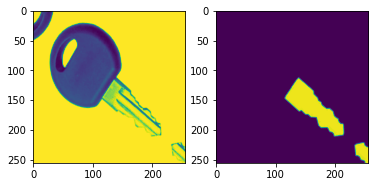

In [ ]:
x=image_generator.next()
y=mask_generator.next()
for i in range(0,1):
  image=x[i]
  mask=y[i]
  plt.subplot(1,2,1)
  plt.imshow(image[:,:,0])
  plt.subplot(1,2,2)
  plt.imshow(mask[:,:,0])

In [ ]:
sm.set_framework('tf.keras')

sm.framework()
model = sm.FPN(backbone_name='efficientnetb0',
                  encoder_weights='imagenet',
                  classes=1,
                  activation='sigmoid')

16818176/16804768 [==============================] - 0s 0us/step


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

In [ ]:
len(X_test)

29

In [ ]:
EarlyStop = tf.keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
Checkpoint = tf.keras.callbacks.ModelCheckpoint('pspnet_model.h5',save_best_only=True)


model.compile(optimizer='adam',
              loss=sm.losses.binary_crossentropy,
              metrics=['accuracy'])

history=model.fit(my_generator,validation_data=valid_generator,epochs=50,
                  steps_per_epoch=len(image_generator)//batch_size,
                  validation_steps=len(mask_generator)//batch_size,
                  callbacks=[EarlyStop,Checkpoint])

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7013

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6/6 [==============================] - 26s 817ms/step - loss: 0.5451 - accuracy: 0.7013 - val_loss: 0.3960 - val_accuracy: 0.9302
Epoch 2/50
6/6 [==============================] - 4s 711ms/step - loss: 0.0976 - accuracy: 0.9348 - val_loss: 0.2789 - val_accuracy: 0.9321
Epoch 3/50
6/6 [==============================] - 2s 339ms/step - loss: 0.0532 - accuracy: 0.9459 - val_loss: 0.4163 - val_accuracy: 0.8791
Epoch 4/50
6/6 [==============================] - 2s 447ms/step - loss: 0.0444 - accuracy: 0.9352 - val_loss: 0.3056 - val_accuracy: 0.8714
Epoch 5/50
6/6 [==============================] - 3s 535ms/step - loss: 0.0378 - accuracy: 0.9423 - val_loss: 0.2008 - val_accuracy: 0.9174
Epoch 6/50
6/6 [==============================] - 3s 539ms/step - loss: 0.0389 - accuracy: 0.9391 - val_loss: 0.1386 - val_accuracy: 0.9296
Epoch 7/50
6/6 [==============================] - 3s 527ms/step - loss: 0.0428 - accuracy: 0.9329 - val_loss: 0.1248 - val_accuracy: 0.9295
Epoch 8/50
6/6 [==============

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


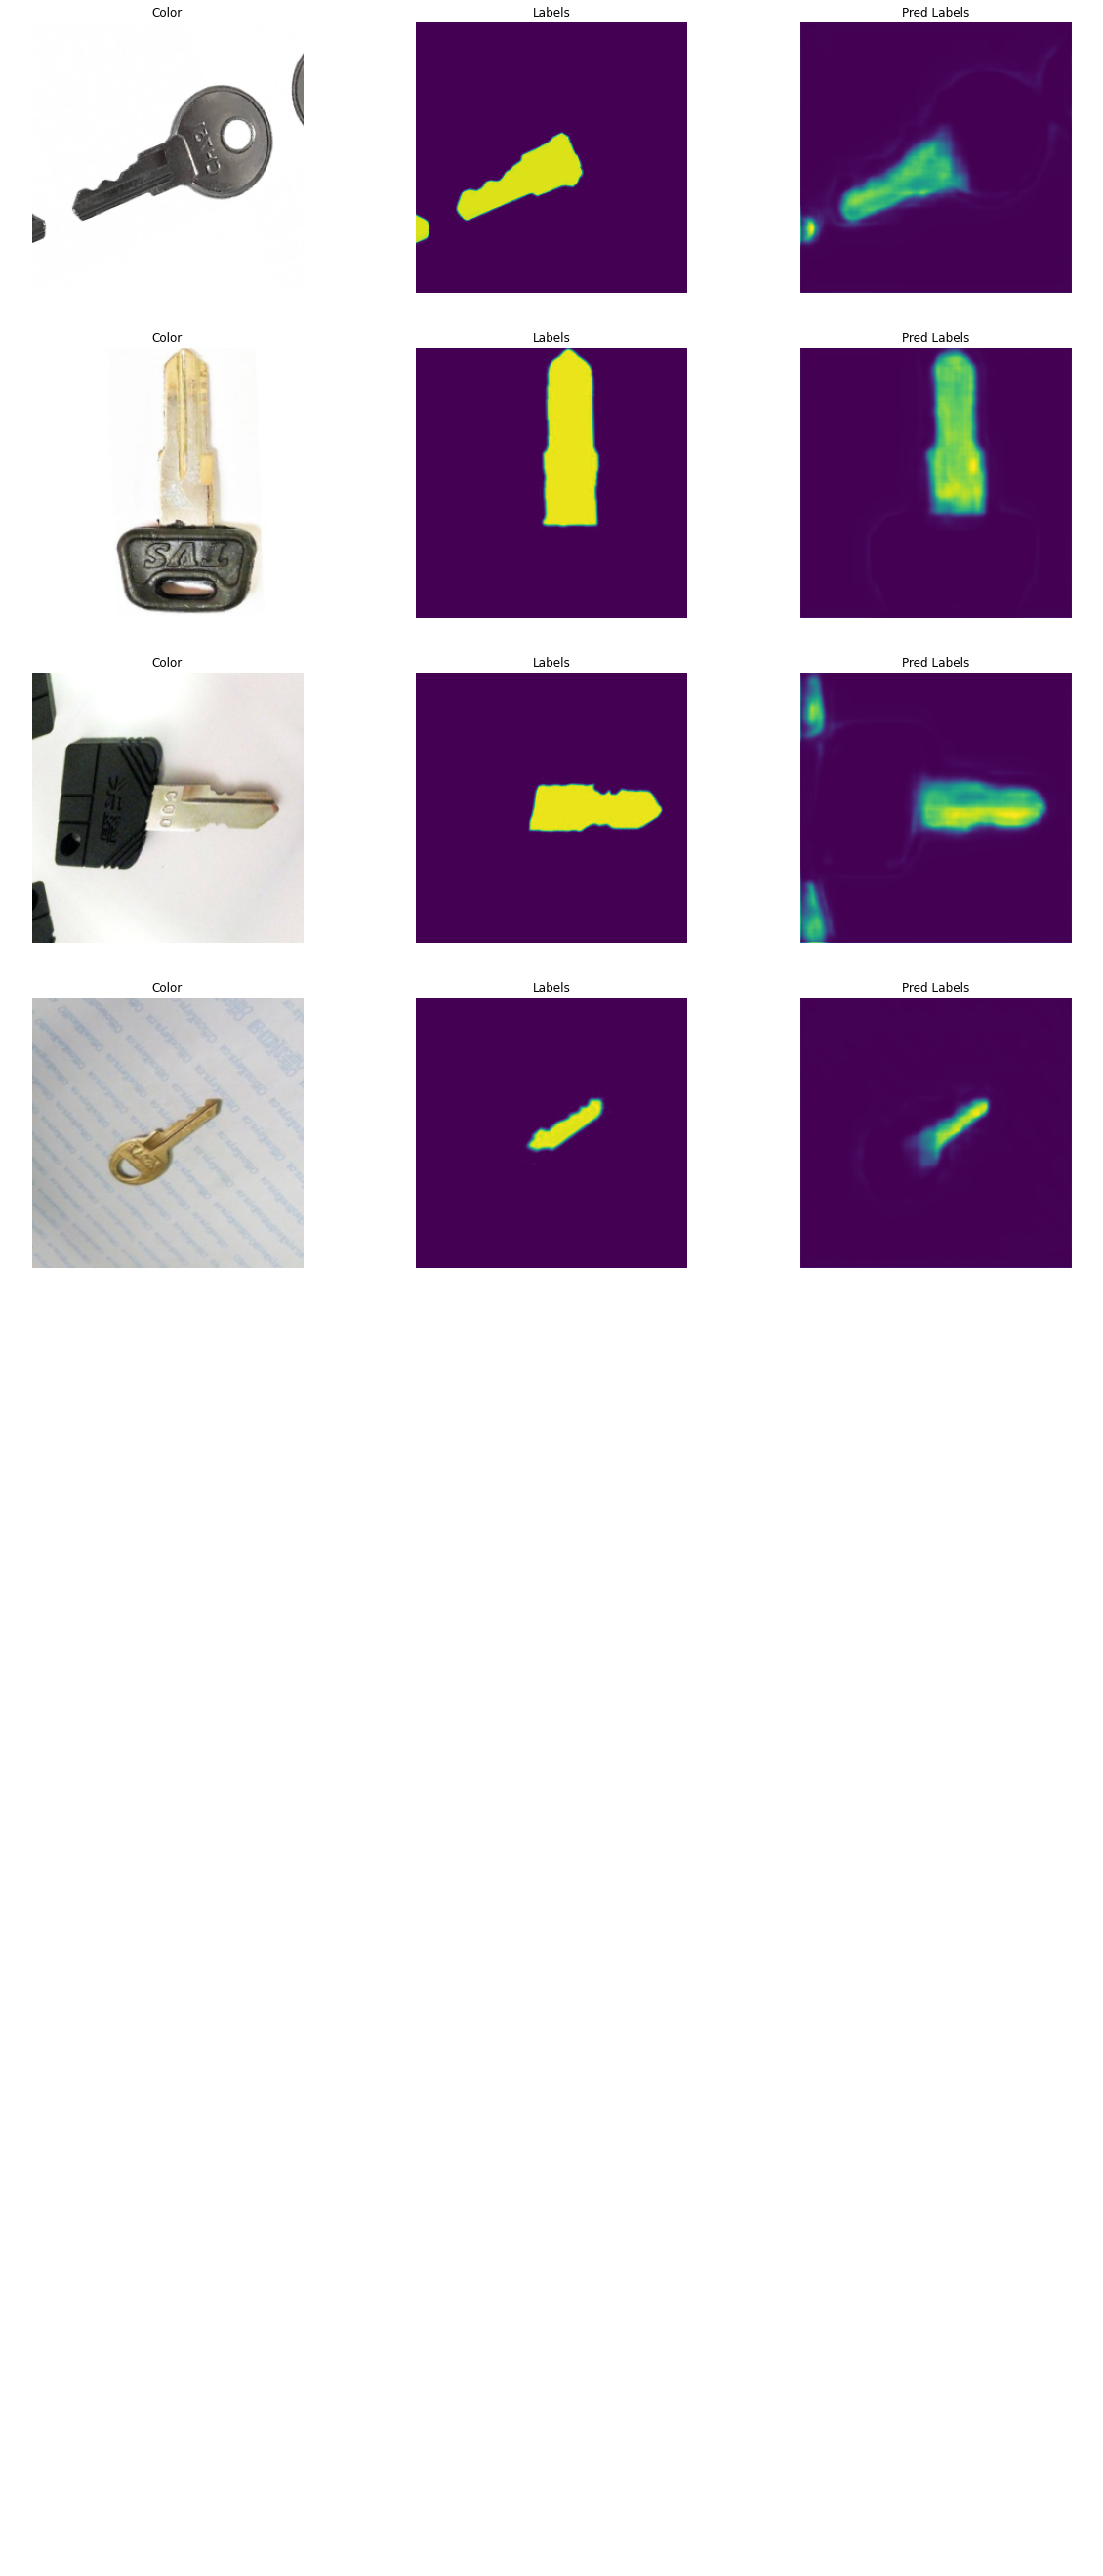

In [ ]:
(rgb_batch, lab_batch) = next(valid_generator)
sample_rows = 8
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax2_pred), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    print(rgb_img.shape)
    lab_pred = model.predict(np.expand_dims(rgb_img,0))[0]

    ax1.imshow(rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0])
    ax2.set_title('Labels')
    ax2_pred.imshow(lab_pred[:,:,0])
    ax2_pred.set_title('Pred Labels')

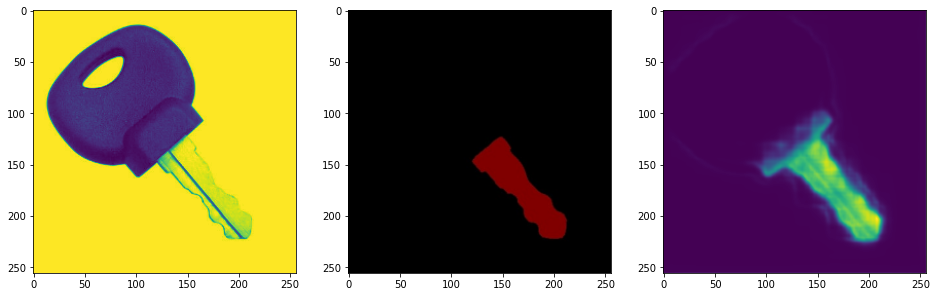

In [ ]:
img_no=random.randint(0,len(X_test))
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(X_test[img_no,:,:,0])
plt.subplot(132)
plt.imshow(y_test[img_no])
plt.subplot(133)
img=np.expand_dims(X_test[img_no],axis=0)
pred=model.predict(img)
pred=cv2.resize(pred[0],(256,256))
plt.imshow(pred)